In [1]:
%matplotlib widget
import contextily as cx
from matplotlib.pyplot import figure, draw, pause
from xyzservices import TileProvider
from matplotlib.axes import Axes
from typing import List, Union, Tuple, Optional, Dict, Callable
import xarray as xa
import numpy as np
import os, logging, traceback
import rioxarray as rio
import matplotlib.pyplot as plt

log_file = os.path.expanduser('~/.spectraclass/logging/geospatial.log')
file_handler = logging.FileHandler(filename=log_file, mode='w')
logger = logging.getLogger(__name__)
logger.addHandler(file_handler)
logger.setLevel(logging.DEBUG)

In [2]:
result_dir = "/Users/tpmaxwel/Development/Data/raster/tiles"
SpectralDataset = f"{result_dir}/DESIS-HSI-L1C-DT0468853252_003-20200628T153803-V0210-SPECTRAL_IMAGE.nc"
dset = xa.open_dataset(SpectralDataset)
raster: xa.DataArray = dset['z']
classes = dict( water='blue', vegetation='green', urban='grey' )
band = 100

/var/folders/k6/40r5lsxs75g91q824qzfvqy40000gn/T/ipykernel_22761/3366970053.py:5: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  raster: xa.DataArray = xa.open_rasterio( SpectralDataset )
ERROR 1: PROJ: proj_identify: Transformation cannot be formatted as WKT1 TOWGS84 parameters


In [3]:
class CallbacksController(object):
    def __init__(self, ax, callbacks: Dict ):
        self.ax = ax
        self.callbacks = callbacks
        self.connect()

    def connect(self):
        logger.info( f" connect: {self.callbacks.keys()}")
        for cid, cback in self.callbacks.items():
            self.ax.callbacks.connect( cid, cback )
        logger.info( f"connect DONE")

    def disconnect(self):
        logger.info( f"disconnect: {self.callbacks.keys()}")
        for cid in self.callbacks.keys():
            self.ax.callbacks.disconnect( cid )
        logger.info( f"disconnect DONE")

    def __enter__(self):
        self.disconnect()

    def __exit__(self):
        self.connect()

class DynamicBasemap(object):

    def __init__(self, ax: Axes, source: TileProvider, **kwargs ):
        self.ax: Axes = ax
        self.source: TileProvider = source
        self.crs: str = kwargs.get('crs',None)
        self.basemap = self.add_basemap( **kwargs )
        self.callbacks_control = CallbacksController( ax, dict( xlim_changed= self.on_lims_change ) )

    def on_lims_change( self, *_ ):
#        stack = "\n".join( traceback.format_stack() )
#        logger.info( f" on_lims_change-> CALLBACK TRACE:\n{stack}")
        self.update_basemap()

    def reproject_bounds(self, left, right, bottom, top, s_crs, t_crs):
        from rasterio.warp import transform_bounds
        n_l, n_b, n_r, n_t = transform_bounds(s_crs, t_crs, left, bottom, right, top)
        return n_l, n_r, n_b, n_t

    def get_basemap_tile(self) -> Tuple[ np.ndarray, Tuple[float] ]:
        from contextily.tile import bounds2img, warp_tiles

        xlim, ylim = self.ax.get_xlim(), self.ax.get_ylim()
        if self.crs is not None:
            xmin, xmax, ymin, ymax = self.reproject_bounds(  xlim[0], xlim[1], ylim[0], ylim[1], self.crs, {"init": "epsg:3857"} )
        else:
            xmin, xmax, ymin, ymax = xlim[0], xlim[1], ylim[0], ylim[1]

        image, extent = bounds2img( xmin, ymin, xmax, ymax, source=self.source, ll=False )

        if self.crs is not None:
            image, extent = warp_tiles( image, extent, t_crs=self.crs )

        if image.shape[2] == 1: image = image[:, :, 0]

        return image, extent

    def update_basemap( self ):
        logger.info( f"update_basemap")
        with self.callbacks_control:
            logger.info( f"get tile")
            image, [minX, maxX, minY, maxY] = self.get_basemap_tile()
            logger.info( f"update axis")
            self.ax.axis((minX, maxX, minY, maxY))
            logger.info( f"update image")
            self.basemap.set_data( image )
            logger.info( f"drawing")
            draw()
        logger.info( f"update_basemap DONE")

    def add_basemap( self, **kwargs ):
        logger.info( f"add_basemap")
        xmin, xmax, ymin, ymax = self.ax.axis()
        image, extent = self.get_basemap_tile()
        img = self.ax.imshow( image, extent=extent )
        self.ax.axis((xmin, xmax, ymin, ymax))
        logger.info( f"add_basemap DONE")
        return img

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
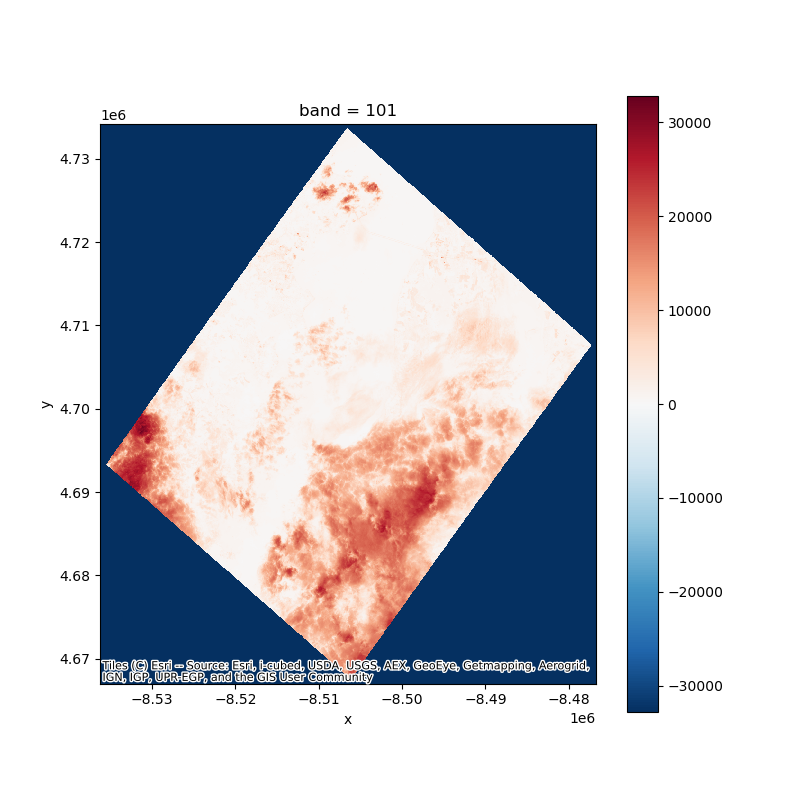

In [4]:
fig, ax = plt.subplots(1,1, figsize=(8.0,8.0) )
raster[band].plot( ax=ax )
basemap = DynamicBasemap( ax, source=cx.providers.Esri.WorldImagery )
plt.show()